# Geospatial Modeling

Here, we attempt to model the data using just the geographic variables: latitude and longitude. We proceed with a nearest-neighbors regressor, where the metric in question is the physical distance between the counties. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Read in the data and define our relevant variables.

In [2]:
df = pd.read_csv('data/cleaned/merged_df.csv')
df.head()

,State,County,Percent of Children with Confirmed BLLs ³5 µg/dL,Built 2020 or later,Built 2000 to 2019,Built 1980 to 1999,Built 1960 to 1979,Built 1940 to 1959,Built 1939 or earlier,Lacking complete plumbing facilities,...,Income in the past 12 months at or above poverty level:!!18 to 64 years,Income in the past 12 months at or above poverty level:!!65 years and over,lat,lng,ADHD Percentage (Ever),ADHD Percentage (Current),ADHD Behavior Treatment(%),ADHD Medication(%),ADHD Meds or BT,Any Treatment
0,AL,AUTAUGA,NaN,0.018971,0.348779,0.233663,0.310232,0.058325,0.030030,0.5,...,0.567738,0.151584,32.5349,-86.6427,12.7,12.1,50.6,77.0,84.3,91.2
1,AL,BALDWIN,NaN,0.016696,0.460808,0.317366,0.156746,0.030529,0.017855,0.3,...,0.515682,0.202625,30.7277,-87.7226,12.7,12.1,50.6,77.0,84.3,91.2
2,AL,BARBOUR,NaN,0.000000,0.171020,0.400188,0.253661,0.104736,0.070395,0.2,...,0.491164,0.187543,31.8696,-85.3932,12.7,12.1,50.6,77.0,84.3,91.2
3,AL,BIBB,NaN,0.000000,0.269087,0.378022,0.226947,0.060487,0.065456,0.7,...,0.501439,0.183021,32.9986,-87.1265,12.7,12.1,50.6,77.0,84.3,91.2
4,AL,BLOUNT,0.0,0.003596,0.272173,0.367732,0.221302,0.092610,0.042588,0.6,...,0.532138,0.165438,33.9809,-86.5674,12.7,12.1,50.6,77.0,84.3,91.2


In [3]:
geo_features = ['lat','lng']
labels = ['State','County']
target = 'Percent of Children with Confirmed BLLs ³5 µg/dL'

In [32]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

We can see a visual snapshot of this in the plot below.

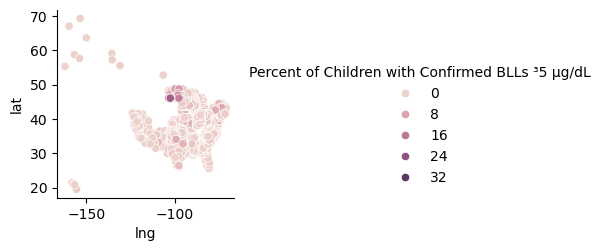

In [10]:
sns.pairplot(df,x_vars=['lng'],y_vars=['lat'],hue=target)

### Split the data into our training set and testing set.

In [20]:
df_geo = df[labels+geo_features+[target]].dropna()
df_train, df_test = train_test_split(df_geo,test_size=0.20,shuffle=True)
df_train.describe()

,lat,lng,Percent of Children with Confirmed BLLs ³5 µg/dL
count,1048.000000,1048.000000,1048.000000
mean,37.898623,-90.861694,1.182271
std,5.523207,11.734684,1.833333
min,19.598400,-159.706200,0.000000
25%,33.551800,-96.280375,0.000000
50%,38.640700,-89.116850,0.500000
75%,41.557675,-83.429650,1.600000
max,69.311900,-71.028800,21.450000


In [21]:
df_train.sort_values(target)

,State,County,lat,lng,Percent of Children with Confirmed BLLs ³5 µg/dL
212,GA,DADE,34.8546,-85.5044,0.00
1255,OK,GREER,34.9357,-99.5608,0.00
256,GA,LAMAR,33.0765,-84.1395,0.00
1734,TX,COKE,31.8886,-100.5300,0.00
827,MS,CHOCTAW,33.3473,-89.2484,0.00
...,...,...,...,...,...
533,IA,WAYNE,40.7395,-93.3274,9.90
1081,NY,FULTON,43.1138,-74.4222,10.20
1981,ND,BARNES,46.9361,-98.0716,11.89
947,MO,IRON,37.5552,-90.7734,12.00


### Cross Validation

We use a grid search to find the optimal number of neighbors for our regressor.

In [37]:
grid_search = GridSearchCV(KNeighborsRegressor(),
                            param_grid = {'n_neighbors':range(3,20)},
                            scoring = 'neg_root_mean_squared_error',
                            cv = 5
                            )

grid_search.fit(df_train[geo_features],df_train[[target]])

best_knn = grid_search.best_estimator_

print('We find that the optimal number of neighbors is '+repr(grid_search.best_params_['n_neighbors'])+
    ' and that the best RMSE is '+repr(-1.0*float(grid_search.best_score_))+'.')

We find that the optimal number of neighbors is 14 and that the best RMSE is 1.5235846841634157.


In [38]:
grid_search.cv_results_

{'mean_fit_time': array([0.00112967, 0.00100107, 0.00075307, 0.00080853, 0.00105462,
        0.00074301, 0.00072613, 0.00069847, 0.00071039, 0.00075703,
        0.00075421, 0.00076609, 0.0007638 , 0.00074077, 0.00072093,
        0.00073209, 0.00074716]),
 'std_fit_time': array([1.23457312e-04, 1.66140454e-04, 2.30631499e-05, 8.33542723e-05,
        1.95397174e-04, 1.78979797e-05, 5.15690072e-06, 7.48133036e-06,
        1.19262683e-05, 3.17966373e-05, 3.50757732e-05, 3.76041051e-05,
        3.36798966e-05, 3.13238826e-05, 1.61937999e-05, 2.67902715e-05,
        2.49470155e-05]),
 'mean_score_time': array([0.00169005, 0.00121212, 0.00091681, 0.00104537, 0.00128579,
        0.00098057, 0.00092578, 0.00093102, 0.000951  , 0.00101132,
        0.00105963, 0.001051  , 0.00103555, 0.00106764, 0.00105872,
        0.00105867, 0.00111237]),
 'std_score_time': array([5.79334631e-04, 2.24330422e-04, 3.97790807e-05, 1.56577205e-04,
        3.08047249e-04, 5.69127472e-05, 1.24863978e-05, 1.68870383e-

### Bagging

We expect the above model with a large number of neighbors to overfit our training data. To combat this, we apply bagging.

In [ ]:
from sklearn.ensemble import BaggingRegressor

In [61]:
bagged_cv = GridSearchCV(BaggingRegressor(max_features=2),
                            param_grid = {'estimator':[KNeighborsRegressor(n_neighbors=n) for n in range(5,20)], 'n_estimators':[10,20,30,40,50]},
                            scoring = 'neg_root_mean_squared_error',
                            cv = 5
                            )

bagged_cv.fit(df_train[geo_features],df_train[[target]].values.reshape(-1))

bagged_best = bagged_cv.best_estimator_

In [62]:
print('We find that the optimal regressor is '+repr(bagged_cv.best_params_['estimator'])+
    ', the optimal number of estimators is '+ repr(bagged_cv.best_params_['n_estimators'])+
    ', and the best RMSE is '+repr(-1.0*float(bagged_cv.best_score_))+'.')

We find that the optimal regressor is KNeighborsRegressor(n_neighbors=16), the optimal number of estimators is 10, and the best RMSE is 1.5179720155177283.


### Look at test data.

In [ ]:
best_knn.fit(df_train[geo_features],df_train[[target]])
preds = best_knn.predict(df_test[geo_features])
root_mean_squared_error(df_test[[target]],preds)

1.9827588822631244

In [63]:
bagged_best.fit(df_train[geo_features],df_train[[target]].values.reshape(-1))
bagged_preds = bagged_best.predict(df_test[geo_features])
root_mean_squared_error(df_test[[target]],bagged_preds)

2.0341339964292326

# Try a gradient boosted tree.

In [36]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [34]:
total_train, total_test = train_test_split(df,test_size=0.20,shuffle=True,random_state=330)

In [ ]:
gbr = HistGradientBoostingRegressor()
total_train[[target]]=total_train[[target]].fillna(0)
features = list(df)[3:]
gbr.fit(total_train[features],total_train[[target]])
#print(features)

/home/mattsmylie/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor()

In [52]:
gbr_preds = gbr.predict(total_test[features])
total_test[[target]] = total_test[[target]].fillna(0)
root_mean_squared_error(total_test[[target]],gbr_preds)

1.6144510825757086

In [53]:
1.61445**2

2.6064488024999997

In [56]:
from sklearn.ensemble import ExtraTreesRegressor

In [57]:
et = ExtraTreesRegressor(n_estimators=100,max_depth=5)

et.fit(total_train[features],total_train[[target]])

/home/mattsmylie/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ExtraTreesRegressor(max_depth=5)

In [58]:
et_preds = et.predict(total_test[features])
#total_test[[target]] = total_test[[target]].fillna(0)
root_mean_squared_error(total_test[[target]],et_preds)

1.643945089043036

In [59]:
et.feature_importances_

array([0.00395224, 0.02136278, 0.02056032, 0.00061261, 0.00266579,
       0.13740745, 0.00044163, 0.00073669, 0.00667484, 0.01314264,
       0.00517826, 0.00434169, 0.00171925, 0.00254404, 0.00158912,
       0.00115636, 0.00204973, 0.00665863, 0.00181914, 0.00337923,
       0.0093942 , 0.00250234, 0.00068312, 0.0065099 , 0.00687618,
       0.00181114, 0.00298463, 0.00183217, 0.0018295 , 0.00249099,
       0.00076257, 0.00199111, 0.00325203, 0.00215683, 0.00206487,
       0.0054573 , 0.00075102, 0.00394859, 0.00102408, 0.00056483,
       0.00108181, 0.00174904, 0.00195177, 0.00229007, 0.00228121,
       0.00149343, 0.00628533, 0.00440133, 0.00324846, 0.00192249,
       0.00182256, 0.00099494, 0.00244808, 0.00054681, 0.00172956,
       0.08642524, 0.07274678, 0.10332874, 0.10884922, 0.08287531,
       0.0830262 , 0.05838692, 0.07323485])

In [60]:
score_df = pd.DataFrame({'feature':total_train[features].columns.values,
                            'importance_score': et.feature_importances_})

score_df.sort_values('importance_score',ascending=False)

,feature,importance_score
5,Built 1939 or earlier,0.137407
58,ADHD Percentage (Current),0.108849
57,ADHD Percentage (Ever),0.103329
55,lat,0.086425
60,ADHD Medication(%),0.083026
...,...,...
22,"Rent Price$3,000 or more",0.000683
3,Built 1960 to 1979,0.000613
39,"Professional, scientific, and management, and ...",0.000565
53,Income in the past 12 months at or above pover...,0.000547


In [61]:
features

['Built 2020 or later',
 'Built 2000 to 2019',
 'Built 1980 to 1999',
 'Built 1960 to 1979',
 'Built 1940 to 1959',
 'Built 1939 or earlier',
 'Lacking complete plumbing facilities',
 'Lacking complete kitchen facilities',
 'House PriceLess than $50,000',
 'House Price$50,000 to $99,999',
 'House Price$100,000 to $149,999',
 'House Price$150,000 to $199,999',
 'House Price$200,000 to $299,999',
 'House Price$300,000 to $499,999',
 'House Price$500,000 to $999,999',
 'House Price$1,000,000 or more',
 'Rent PriceLess than $500',
 'Rent Price$500 to $999',
 'Rent Price$1,000 to $1,499',
 'Rent Price$1,500 to $1,999',
 'Rent Price$2,000 to $2,499',
 'Rent Price$2,500 to $2,999',
 'Rent Price$3,000 or more',
 'Owner occupied',
 'Renter occupied',
 'Under 19 years:!!With health insurance coverage',
 'Under 19 years:!!No health insurance coverage',
 '19 to 64 years:!!With health insurance coverage',
 '19 to 64 years:!!No health insurance coverage',
 '65 years and over:!!With health insurance 